<a href="https://colab.research.google.com/github/bvchand/Diabetes-detection-in-ICU-patients/blob/main/diabetes_data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sqlite3
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from fancyimpute import IterativeImputer

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd '/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021'

/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021


## Data Extraction

In [4]:
data_dict = pd.read_csv("DataDictionaryWiDS2021.csv")
data_dict

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,demographic,age,Years,numeric,The age of the patient on unit admission,None
3,demographic,bmi,kilograms/metres^2,string,The body mass index of the person on unit admi...,21.5
4,demographic,elective_surgery,None,binary,Whether the patient was admitted to the hospit...,0
...,...,...,...,...,...,...
176,APACHE comorbidity,immunosuppression,None,binary,Whether the patient has their immune system su...,1
177,APACHE comorbidity,leukemia,None,binary,Whether the patient has been diagnosed with ac...,1
178,APACHE comorbidity,lymphoma,None,binary,Whether the patient has been diagnosed with no...,1
179,APACHE comorbidity,solid_tumor_with_metastasis,None,binary,Whether the patient has been diagnosed with an...,1


In [5]:
diabetes_train = pd.read_csv("TrainingWiDS2021.csv")
diabetes_train

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.450,33.0,...,11.3,11.3,36.9,36.9,1.30,1.30,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.450,7.450,51.0,51.0,54.8,51.000000,37.0,37.0,7.450,7.450,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.390,4.0,...,11.6,11.6,34.0,34.0,1.60,1.10,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.440,7.340,337.0,102.0,342.5,236.666667,36.0,33.0,7.370,7.340,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,130153,164758,7,50.0,29.287256,0,Caucasian,M,175.3,Emergency Department,Accident & Emergency,1109,admit,Cardiac ICU,0.023611,0,90.0,NaN,110.0,104.01,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,106.0,NaN,0,120.0,NaN,NaN,NaN,NaN,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
130153,130154,197653,7,79.0,29.653433,0,Caucasian,F,162.6,Direct Admit,Accident & Emergency,1106,admit,MICU,0.009722,0,78.4,3.5,105.0,207.01,0,0,0.7,32.0,1.07,NaN,4.0,6.0,0.0,

## Data Exploration

In [6]:
diabetes_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,130157.0,65079.000000,37573.233831,1.000000,32540.000000,65079.000000,97618.000000,130157.00000
encounter_id,130157.0,213000.856519,38109.828146,147000.000000,180001.000000,213014.000000,246002.000000,279000.00000
hospital_id,130157.0,106.102131,63.482277,1.000000,49.000000,112.000000,165.000000,204.00000
age,125169.0,61.995103,16.822880,0.000000,52.000000,64.000000,75.000000,89.00000
bmi,125667.0,29.110260,8.262776,14.844926,23.598006,27.564749,32.803127,67.81499
...,...,...,...,...,...,...,...,...
immunosuppression,130157.0,0.025669,0.158146,0.000000,0.000000,0.000000,0.000000,1.00000
leukemia,130157.0,0.007307,0.085166,0.000000,0.000000,0.000000,0.000000,1.00000
lymphoma,130157.0,0.004187,0.064574,0.000000,0.000000,0.000000,0.000000,1.00000
solid_tumor_with_metastasis,130157.0,0.020852,0.142888,0.000000,0.000000,0.000000,0.000000,1.00000


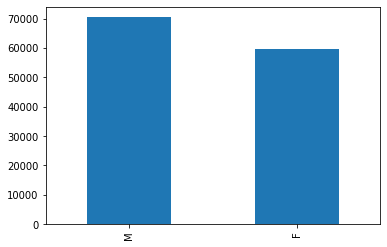

In [7]:
# look at gender distribution
gender = diabetes_train["gender"].value_counts()
gender.plot(kind="bar")

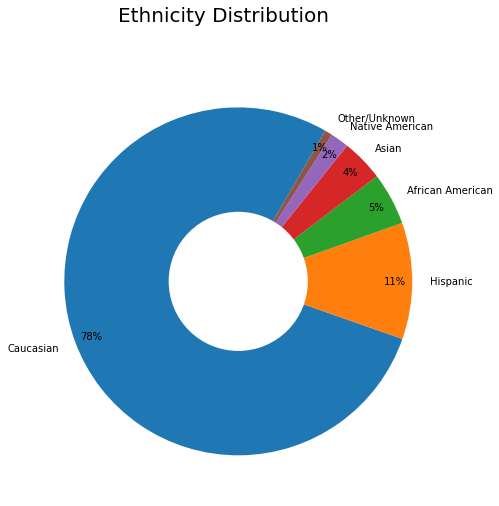

In [8]:
# look at ethnicity distribution
#diabetes_train['ethnicity'].unique() #to get values for labels
labels = ['Caucasian', 'Hispanic', 'African American', 'Asian',
       'Native American', 'Other/Unknown']
fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Ethnicity Distribution', size = 20)
sizes = diabetes_train["ethnicity"].value_counts()
ax.pie(sizes, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

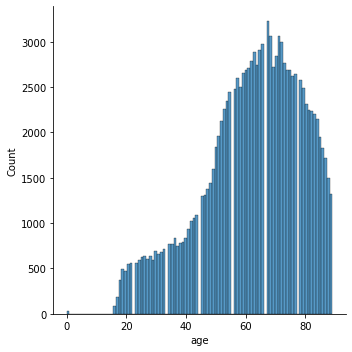

In [ ]:
# look at age distribution
ax = sns.displot(diabetes_train['age']);
# looks like we have some counts against age=0
#most of the patients lie in the 60-80 age range

In [ ]:
sizes

Caucasian           100236
African American     13911
Other/Unknown         6261
Hispanic              5049
Asian                 2198
Native American        915
Name: ethnicity, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


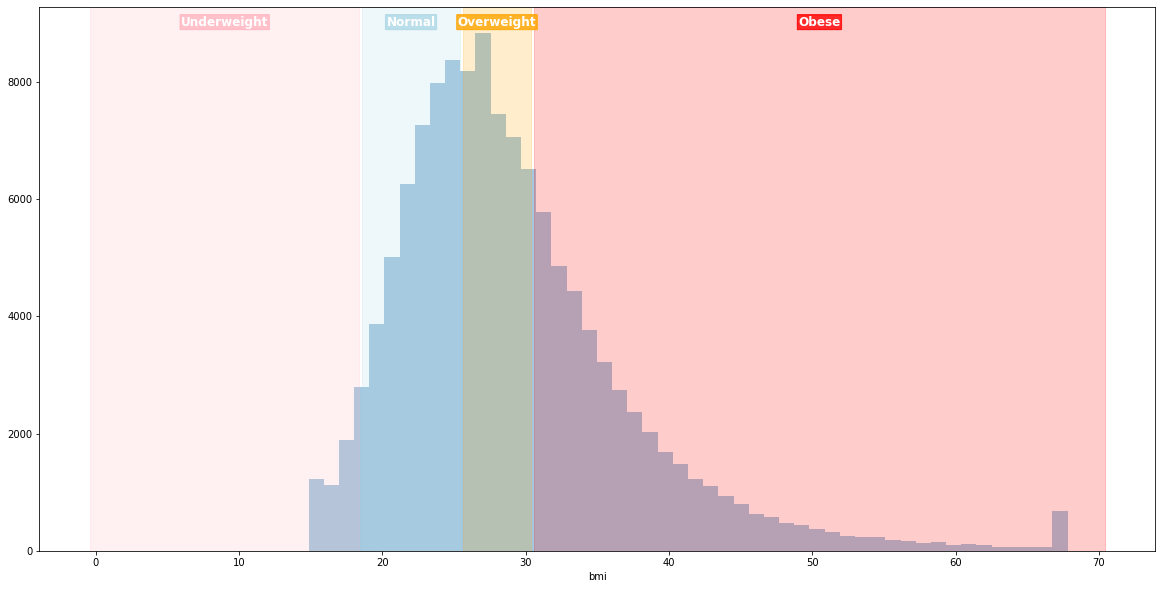

In [9]:
#BMI is important, we can see the distribution
span_range = [[0,18], [19,25], [26,30], [31,70]]
span_color =  ['#FFB6C1','#ADD8E6','orange','red']

fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax = sns.distplot(diabetes_train['bmi'],kde=False);

for idx, span_title in enumerate(['Underweight','Normal','Overweight', 'Obese']):
    ax.annotate(span_title,
                    xy=(sum(span_range[idx])/2 ,1000),
                    xytext=(0,470), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=10, fontweight='bold',
                    size=12,
                    bbox=dict(boxstyle='sawtooth', pad=0.1, color=span_color[idx], alpha=0.8))
    #draw a color rectangle
    ax.axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=span_color[idx], alpha=0.2)
# plt.title("Distribution of BMI", size = 20)
plt.show()



# Ranges taken from 
#https://www.cdc.gov/obesity/adult/defining.html#:~:text=Adult%20Body%20Mass%20Index%20(BMI)&text=If%20your%20BMI%20is%20less,falls%20within%20the%20obesity%20range.

In [ ]:
diabetes_train.dtypes.value_counts()

float64    157
int64       18
object       6
dtype: int64

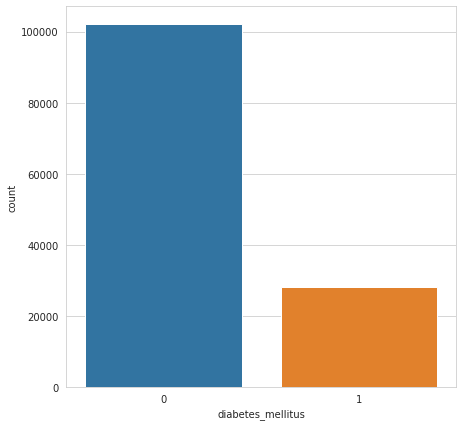

In [16]:
#plot to get an idea of target variable distribution
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.countplot(x='diabetes_mellitus',data=diabetes_train, ax=ax)

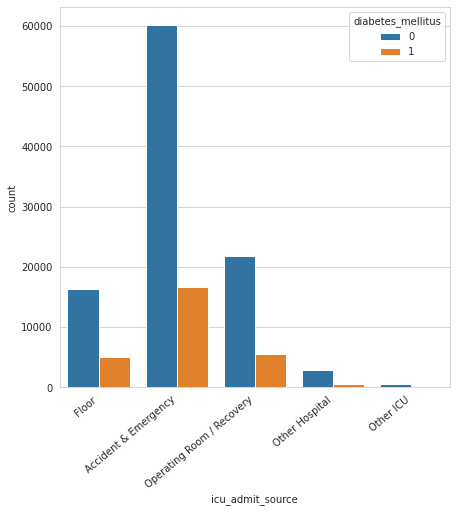

In [17]:
#plot to know the relationship of 'icu_addmit_source' with target.
#We can use same plot for other attributes while deciding on feature selection
fig, ax = plt.subplots(figsize=(7,7))
ax=sns.countplot(x='icu_admit_source',hue='diabetes_mellitus',data=diabetes_train, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()


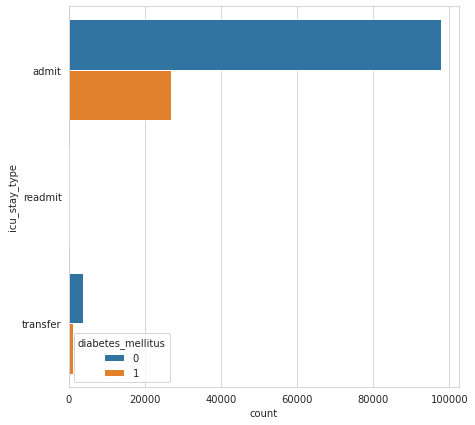

In [19]:
#plot to know the relationship of 'icu_stay_type' with target.
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.countplot(y='icu_stay_type',hue='diabetes_mellitus',data=diabetes_train, ax=ax)

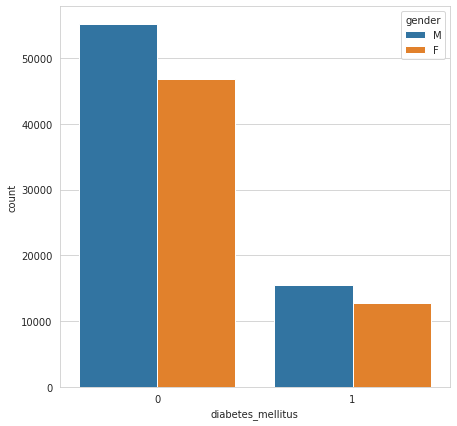

In [21]:
#plot to know the relationship of 'gender' with target.
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.countplot(x='diabetes_mellitus',hue='gender',data=diabetes_train, ax=ax)

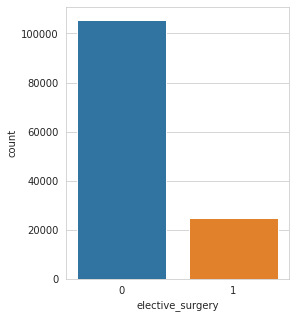

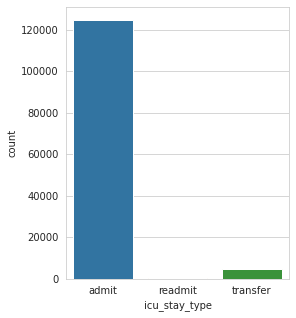

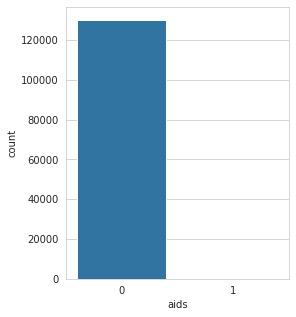

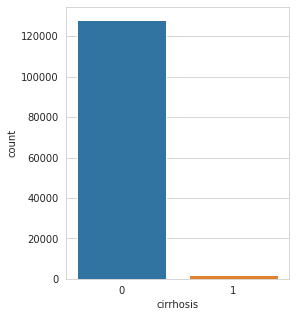

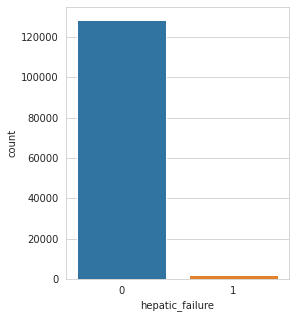

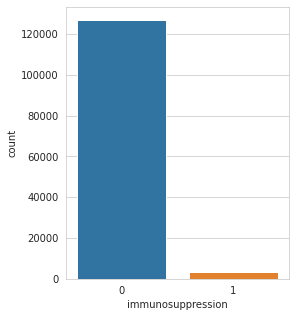

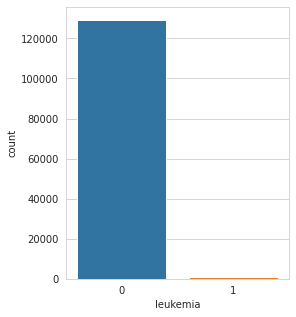

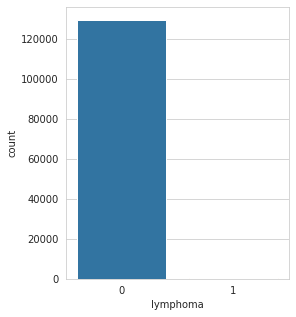

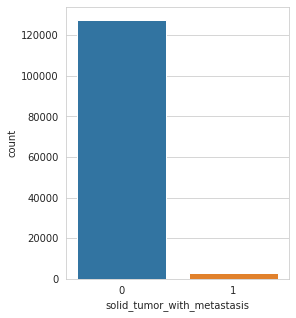

In [ ]:
columns_to_drop = ['elective_surgery','icu_stay_type','aids','cirrhosis','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']

for col in columns_to_drop:
  plt.figure(figsize=(4,5))
  sns.countplot(x=col, data=diabetes_train)
  plt.show()


In [ ]:
# features that are categorical

for cols in diabetes_train.columns:
    if(diabetes_train[cols].dtype == object):
        print("{0} : {1}".format(cols, diabetes_train[cols].dtype))

ethnicity : object
gender : object
hospital_admit_source : object
icu_admit_source : object
icu_stay_type : object
icu_type : object


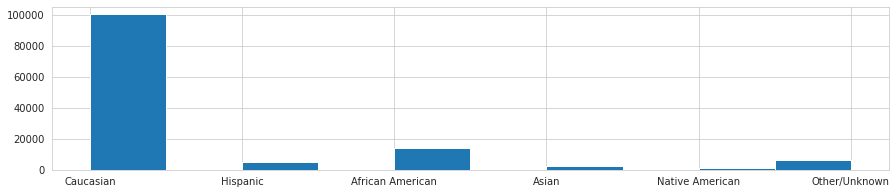

In [ ]:
diabetes_train['ethnicity'].hist(figsize=(15,3))

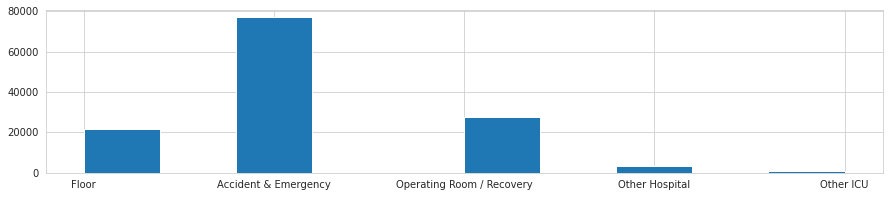

In [ ]:
diabetes_train['icu_admit_source'].hist(figsize=(15,3))

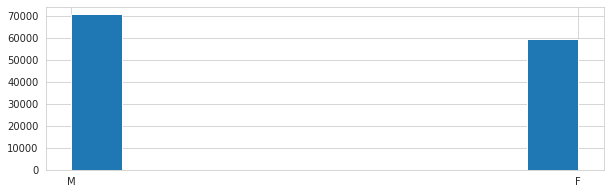

In [ ]:
diabetes_train['gender'].hist(figsize=(10,3))

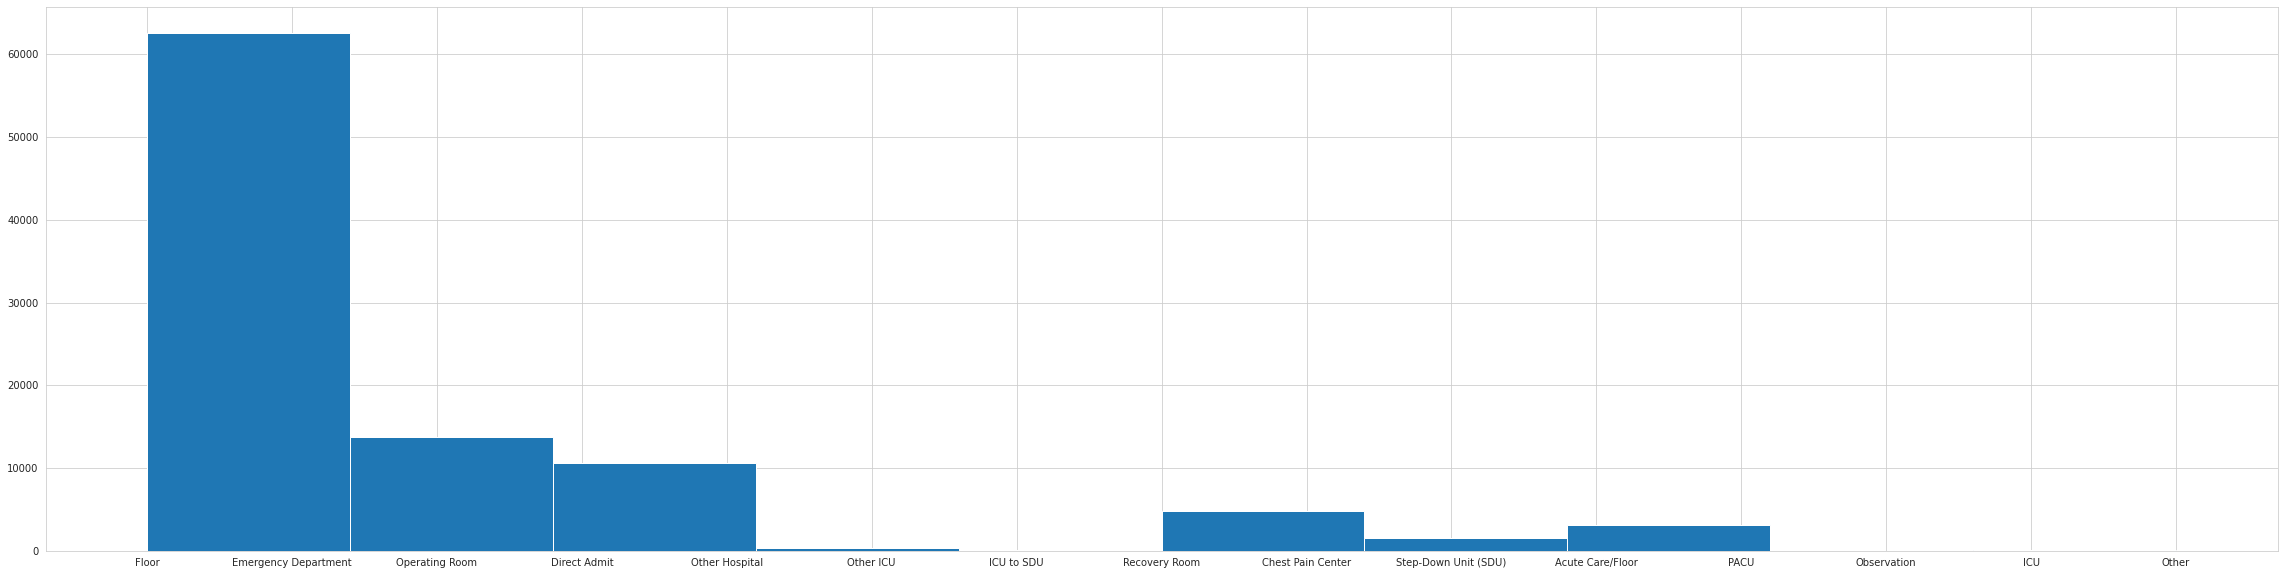

In [ ]:
diabetes_train['hospital_admit_source'].hist(figsize=(40,10))

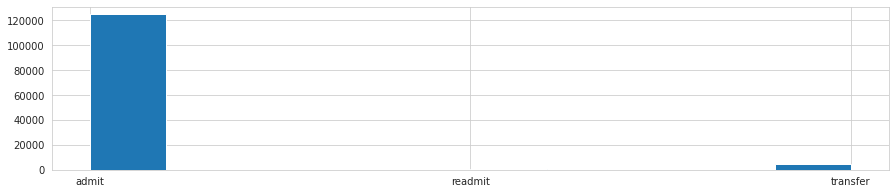

In [ ]:
diabetes_train['icu_stay_type'].hist(figsize=(15,3))

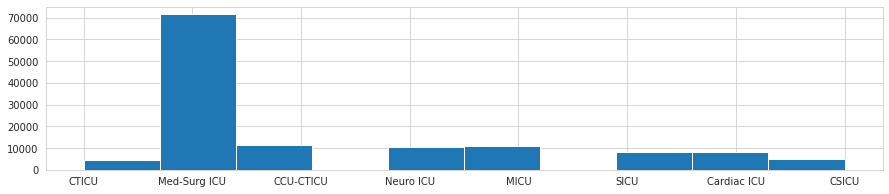

In [ ]:
diabetes_train['icu_type'].hist(figsize=(15,3))

In [ ]:
pickle.dump(diabetes_train, open("diabetes_train.pkl", "wb"))